In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import pandas as pd
import pathlib
from keras_tuner.tuners import RandomSearch


base_dir = './Dataset 2' 

In [ ]:
data_dir = pathlib.Path('./Dataset 2')

all_images = list(data_dir.glob('*/*.jpg'))
all_labels = [p.parent.name for p in all_images]


train_files, rest_files, train_labels, rest_labels = train_test_split(all_images, all_labels,
                                                                    test_size=0.3,
                                                                    random_state=42)


validation_files, test_files, validation_labels, test_labels = train_test_split(rest_files, rest_labels,
                                                                               test_size=0.333, 
                                                                               random_state=42)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_df = pd.DataFrame({'filename': [str(f) for f in train_files],
                         'class': train_labels})

validation_df = pd.DataFrame({'filename': [str(f) for f in validation_files],
                             'class': validation_labels})

test_df = pd.DataFrame({'filename': [str(f) for f in test_files],
                       'class': test_labels})

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1706 validated image filenames belonging to 2 classes.
Found 488 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50

def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hp.Int('units1', min_value=64, max_value=512, step=64), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units3', min_value=16, max_value=128, step=16), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.1))(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='pharyngitis_resnet50'
)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[stop_early]
)


Trial 20 Complete [00h 07m 32s]
val_accuracy: 0.5758196711540222

Best val_accuracy So Far: 0.6618852615356445
Total elapsed time: 04h 21m 14s


In [16]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

c:\Users\izzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,416,193 (93.14 MB)

 Trainable params: 828,481 (3.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')

c:\Users\izzam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6888 - loss: 0.6381
Test Accuracy: 0.70


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters:")
print(f" - units1: {best_hps.get('units1')}")
print(f" - units2: {best_hps.get('units2')}")
print(f" - units3: {best_hps.get('units3')}")
print(f" - dropout1: {best_hps.get('dropout1')}")
print(f" - dropout2: {best_hps.get('dropout2')}")
print(f" - dropout3: {best_hps.get('dropout3')}")
print(f" - Learning Rate: {best_hps.get('lr')}")

Best hyperparameters:
 - units1: 384
 - units2: 96
 - units3: 48
 - dropout1: 0.2
 - dropout2: 0.2
 - dropout3: 0.2
 - Learning Rate: 0.001


In [ ]:

best_model = tuner.hypermodel.build(best_hps)

for layer in best_model.layers[:10]:
    layer.trainable = True
history = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.5849 - loss: 0.7679 - val_accuracy: 0.5758 - val_loss: 0.6881
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.7338 - loss: 0.5238 - val_accuracy: 0.5758 - val_loss: 0.6842
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8042 - loss: 0.4391 - val_accuracy: 0.5758 - val_loss: 0.6810
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.8288 - loss: 0.3900 - val_accuracy: 0.5758 - val_loss: 0.6862
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8068 - loss: 0.3965 - val_accuracy: 0.5758 - val_loss: 0.8191
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8800 - loss: 0.2988 - val_accuracy: 0.5758 - val_loss: 0.7355
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8280 - loss: 0.3761 - val_accuracy: 0.5758 - val_loss: 0.7327
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8961 - loss: 0.2695 - val_accuracy: 0.

In [ ]:
best_model.save('tuner_resnet50_pharyngitis_model2.keras')

In [26]:
best_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,100,933 (99.57 MB)

 Trainable params: 842,369 (3.21 MB)

 Non-trainable params: 23,573,824 (89.93 MB)

 Optimizer params: 1,684,740 (6.43 MB)

In [27]:
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9652 - loss: 0.2038
Test Accuracy: 0.96


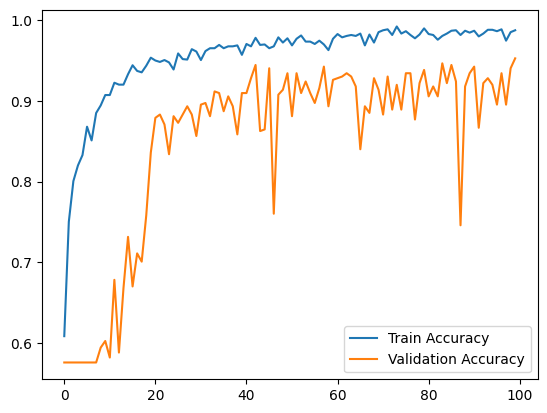

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Evaluasi best_model hasil tuning:
              precision    recall  f1-score   support

  faringitis       0.93      0.98      0.95       108
      normal       0.98      0.94      0.96       136

    accuracy                           0.96       244
   macro avg       0.96      0.96      0.96       244
weighted avg       0.96      0.96      0.96       244



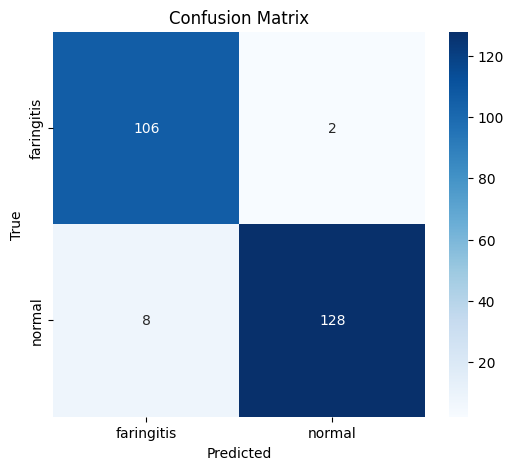

In [29]:
test_generator.reset()
Y_pred_best = best_model.predict(test_generator)
y_pred_best = (Y_pred_best > 0.5).astype(int).reshape(-1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluasi best_model hasil tuning:")
print(classification_report(test_generator.classes, y_pred_best, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
